In [3]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil


seed = 7
tf.random.set_seed(seed)

2022-11-28 11:34:27.500512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 11:34:27.686823: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 11:34:28.417392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-28 11:34:28.417476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [4]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [31]:
scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        
        encoder.fit(x_test)
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global scaler
    
    scaler = StandardScaler()
    
    train = pd.read_csv("../data/ML-CUP22-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)
    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    x_test = test.to_numpy().astype(np.float64)
    
    if scale:
        # scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)
        y_train = scaler.fit_transform(y_train)
        
    return x_train, y_train, x_test, None
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [46]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations



def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        
    init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    
    activation = config["activations_1"]
    n_units = config["units_1"]
    model.add(Dense(n_units, input_dim=input_size, activation=activation,
                    kernel_regularizer=reg, bias_regularizer=reg,
                    kernel_initializer = init, bias_initializer = init))
    
    for l in range(2,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation,
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        
    if task == "classification":
        model.add(Dense(output_size, activation="sigmoid",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        model.add(Dense(output_size, activation="linear",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mse'])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mse"
        val_metric = "val_mse"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=[early_stop], verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
        
        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}")
        
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mse"
        val_metric = "val_mse"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"],
        min_delta=early_stopping["delta"], 
    )
    
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_model_test(x_train, y_train, x_test, y_test, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        test_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mse"
        test_metric = "val_mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    trials = config["trials_test"]
    
    if early_stopping["monitor"] == "val_loss":
        early_stopping["monitor"] = "loss"
        
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_test_loss = []
    trials_train_loss = []
    trials_test_acc = []
    trials_train_acc = []
    
    trials_history_test_loss = []
    trials_history_train_loss = []
    trials_history_test_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_test, y_test),
                                batch_size=batch_size, verbose=0, callbacks=[early_stop])

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_test_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_test_acc = history.history[test_metric]

            trials_test_loss.append(trial_test_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_acc.append(trial_test_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_test_loss.append(trial_test_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_acc.append(trial_test_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} test_loss: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")
            print(f"Trial {trial+1}/{trials} {train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_test_loss)
    med_test_loss = trials_test_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_test_acc = trials_test_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_test_loss = np.std(trials_test_loss)
    std_train_loss = np.std(trials_train_loss)
    std_test_acc = np.std(trials_test_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian test_loss: {med_test_loss}, std test_loss {std_test_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median test_{train_metric}: {med_test_acc}, std test_{train_metric} {std_test_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    plot_curves(train_acc, "Training accuracy", test_acc, "Test accuracy")
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    
    med_model = models[med_idx]
    
    return med_model


def fit_model_no_test(x_train, y_train, config):
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
    elif task == "regression":
        train_metric = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    trials = config["trials_test"]
    
    if early_stopping["monitor"] == "val_loss":
        early_stopping["monitor"] = "loss"
        
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_train_loss = []
    trials_train_acc = []
    
    trials_history_train_loss = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs,
                                batch_size=batch_size, verbose=0, callbacks=[early_stop])

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_train_acc = history.history[train_metric]

            trials_train_loss.append(trial_train_loss[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_train_loss.append(trial_train_loss)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_train_loss)
    med_train_loss = trials_train_loss[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_train_loss = np.std(trials_train_loss)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
    
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    plot_curves(train_acc, "Training accuracy")
    
    train_loss = trials_history_train_loss[med_idx]
    plot_curves(train_loss, "Train loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)

    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}, x_test=None, y_test=None ):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    if x_test is None:
        model = fit_model_no_test(x_train, y_train, best_conf)
    else:
        model = fit_model_test(x_train, y_train, x_test, y_test, best_conf)
        
    return model

In [16]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "nesterov": False,
    "momentum": [0.9],
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

# Monks 1

In [17]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}

Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.20s/it]


Fold 1/5 median val_loss: 0.2155199497938156
Fold 1/5 median train_loss: 0.07520170509815216
Fold 1/5 median val_accuracy: 0.7599999904632568
Fold 1/5 median train_accuracy: 0.9494949579238892

Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.99s/it]


Fold 2/5 median val_loss: 0.002941928105428815
Fold 2/5 median train_loss: 0.002205116441473365
Fold 2/5 median val_accuracy: 1.0
Fold 2/5 median train_accuracy: 1.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.69s/it]


Fold 3/5 median val_loss: 0.14889578521251678
Fold 3/5 median train_loss: 0.06175023689866066
Fold 3/5 median val_accuracy: 0.800000011920929
Fold 3/5 median train_accuracy: 0.939393937587738

Executing fold 4/5


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]


Fold 4/5 median val_loss: 0.0025225747376680374
Fold 4/5 median train_loss: 0.0019286886090412736
Fold 4/5 median val_accuracy: 1.0
Fold 4/5 median train_accuracy: 1.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


Fold 5/5 median val_loss: 0.13105006515979767
Fold 5/5 median train_loss: 0.03044525906443596
Fold 5/5 median val_accuracy: 0.8333333134651184
Fold 5/5 median train_accuracy: 0.9800000190734863

Mean val_loss: 0.10018606060184539, std val_loss: 0.08440581475380639
Mean train_loss: 0.034306201222352686, std train_loss: 0.03006428835991005
Mean val_accuracy: 0.8786666631698609, std val_accuracy: 0.10175351696929383
Mean train_accuracy: 0.8786666631698609, std train_accuracy: 0.025242147173153467






Best configuration (loss 0.10018606060184539):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


 10%|████▍                                       | 1/10 [00:08<01:19,  8.81s/it]

Trial 1/10 test_loss: 0.0026623932644724846
Trial 1/10 train_loss: 0.002312032738700509
Trial 1/10 val_accuracy: 1.0
Trial 1/10 accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:16<01:03,  7.97s/it]

Trial 2/10 test_loss: 0.004875623621046543
Trial 2/10 train_loss: 0.0021880653221160173
Trial 2/10 val_accuracy: 1.0
Trial 2/10 accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:22<00:51,  7.34s/it]

Trial 3/10 test_loss: 0.002709096996113658
Trial 3/10 train_loss: 0.0011013549519702792
Trial 3/10 val_accuracy: 1.0
Trial 3/10 accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:30<00:44,  7.46s/it]

Trial 4/10 test_loss: 0.0905192568898201
Trial 4/10 train_loss: 0.06697633117437363
Trial 4/10 val_accuracy: 0.9166666865348816
Trial 4/10 accuracy: 0.9354838728904724


 50%|██████████████████████                      | 5/10 [00:38<00:38,  7.67s/it]

Trial 5/10 test_loss: 0.003435048507526517
Trial 5/10 train_loss: 0.002893169643357396
Trial 5/10 val_accuracy: 1.0
Trial 5/10 accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:44<00:29,  7.27s/it]

Trial 6/10 test_loss: 0.003195578930899501
Trial 6/10 train_loss: 0.002630450064316392
Trial 6/10 val_accuracy: 1.0
Trial 6/10 accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [00:53<00:23,  7.82s/it]

Trial 7/10 test_loss: 0.11187154799699783
Trial 7/10 train_loss: 0.06600293517112732
Trial 7/10 val_accuracy: 0.8773148059844971
Trial 7/10 accuracy: 0.9354838728904724


 80%|███████████████████████████████████▏        | 8/10 [01:01<00:15,  7.73s/it]

Trial 8/10 test_loss: 0.01247330754995346
Trial 8/10 train_loss: 0.002156523521989584
Trial 8/10 val_accuracy: 0.9884259104728699
Trial 8/10 accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:08<00:07,  7.66s/it]

Trial 9/10 test_loss: 0.08603548258543015
Trial 9/10 train_loss: 0.06581909209489822
Trial 9/10 val_accuracy: 0.9166666865348816
Trial 9/10 accuracy: 0.9354838728904724


100%|███████████████████████████████████████████| 10/10 [01:15<00:00,  7.52s/it]

Trial 10/10 test_loss: 0.08763965219259262
Trial 10/10 train_loss: 0.06593318283557892
Trial 10/10 val_accuracy: 0.9166666865348816
Trial 10/10 accuracy: 0.9354838728904724

Median test_loss: 0.01247330754995346, std test_loss 0.044239453539031144
Median train_loss: 0.002156523521989584, std train_loss 0.03134279791008108
Median test_accuracy: 0.9884259104728699, std test_accuracy 0.046101436702220215
Median train_accuracy: 1.0, std train_accuracy 0.031606318319776706


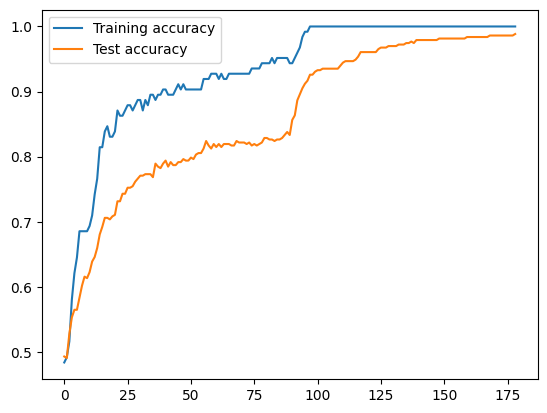

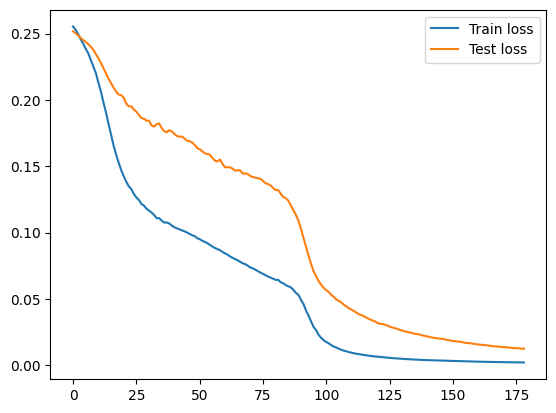

14/14 [==============================] - 0s 1ms/step - loss: 0.0125 - accuracy: 0.9884
[0.01247330754995346, 0.9884259104728699]


In [18]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

# Monks 2

In [137]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [138]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}
Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.43s/it]


Fold 1/5 median val_loss: 0.22347776591777802
Fold 1/5 median train_loss: 0.2325308471918106
Fold 1/5 median val_accuracy: 0.6764705777168274
Fold 1/5 median train_accuracy: 0.6074073910713196
Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.74s/it]


Fold 2/5 median val_loss: 0.002169596264138818
Fold 2/5 median train_loss: 0.0015933680115267634
Fold 2/5 median val_accuracy: 1.0
Fold 2/5 median train_accuracy: 1.0
Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.93s/it]


Fold 3/5 median val_loss: 0.0023157440591603518
Fold 3/5 median train_loss: 0.0017830441938713193
Fold 3/5 median val_accuracy: 1.0
Fold 3/5 median train_accuracy: 1.0
Executing fold 4/5


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.67s/it]


Fold 4/5 median val_loss: 0.07802432775497437
Fold 4/5 median train_loss: 0.08665571361780167
Fold 4/5 median val_accuracy: 0.9117646813392639
Fold 4/5 median train_accuracy: 0.8962963223457336
Executing fold 5/5


100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]

Fold 5/5 median val_loss: 0.23593862354755402
Fold 5/5 median train_loss: 0.16424164175987244
Fold 5/5 median val_accuracy: 0.6060606241226196
Fold 5/5 median train_accuracy: 0.7573529481887817
Mean val_loss: 0.10838521150872112
Mean train_loss: 0.09736092295497656
Mean val_accuracy: 0.8388591766357422
Mean train_accuracy: 0.8388591766357422






Best configuration (loss 0.10838521150872112):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Monks 3

In [15]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': None, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.76s/it]

0.23260994602081386



{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': None, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'activations_1': 'relu', 'units_1': 5}
0.23260994602081386


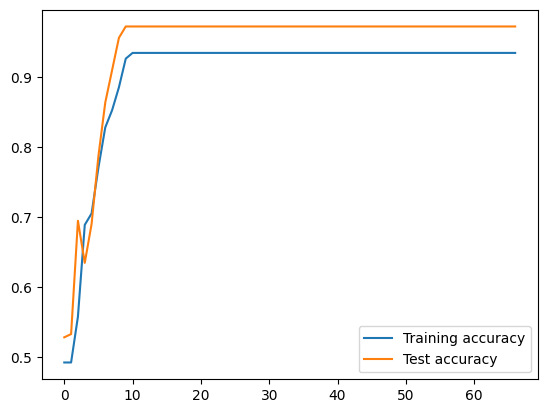

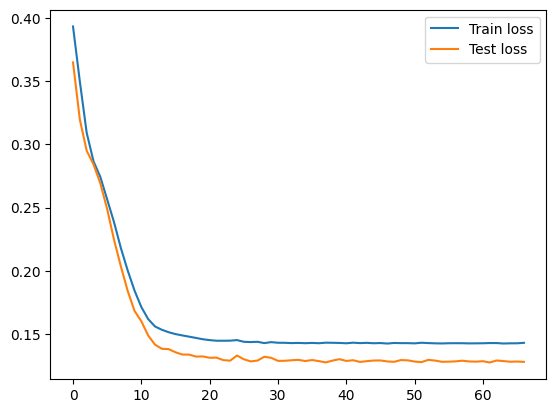

14/14 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9722
[0.12798188626766205, 0.9722222089767456]


In [20]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

# ML Cup

In [37]:
x_train, y_train, x_test, _ = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape)

(1492, 9) (1492, 2)
(529, 9)


In [43]:
params = {
    "task": "regression",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "nesterov": False,
    "momentum": [0.9],
    "regularization": [
        {
            "type": "l1",
            "value": [0.01]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [10],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/2:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.96s/it]


Median val_loss: 0.23456059396266937, std val_loss 0.017538398541062747
Median train_loss: 0.23050011694431305, std train_loss 0.00964827230609172
Median val_mse: 0.13625304400920868, std val_mse 0.018903014619817356
Median train_mse: 0.13175348937511444, train_mse 0.008575083142632374



Testing configuration 2/2:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 5, 'activations_2': 'relu', 'units_2': 5}


100%|█████████████████████████████████████████████| 5/5 [00:16<00:00,  3.33s/it]


Median val_loss: 0.24927929043769836, std val_loss 0.014126756520871859
Median train_loss: 0.2470225840806961, std train_loss 0.013974644638408223
Median val_mse: 0.14913298189640045, std val_mse 0.014507426563673178
Median train_mse: 0.14290718734264374, train_mse 0.004033229356093412






Best configuration (loss 0.23456059396266937):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 5}


 10%|████▍                                       | 1/10 [00:02<00:19,  2.12s/it]

Trial 1/10 train_loss: 0.23074139654636383
Trial 1/10 mse: 0.13824854791164398


 20%|████████▊                                   | 2/10 [00:04<00:19,  2.49s/it]

Trial 2/10 train_loss: 0.21265102922916412
Trial 2/10 mse: 0.11641083657741547


 30%|█████████████▏                              | 3/10 [00:08<00:20,  2.92s/it]

Trial 3/10 train_loss: 0.23341551423072815
Trial 3/10 mse: 0.14005962014198303


 40%|█████████████████▌                          | 4/10 [00:10<00:16,  2.75s/it]

Trial 4/10 train_loss: 0.25830143690109253
Trial 4/10 mse: 0.1592618227005005


 50%|██████████████████████                      | 5/10 [00:13<00:13,  2.76s/it]

Trial 5/10 train_loss: 0.2101162225008011
Trial 5/10 mse: 0.1252640336751938


 60%|██████████████████████████▍                 | 6/10 [00:16<00:11,  2.77s/it]

Trial 6/10 train_loss: 0.20805956423282623
Trial 6/10 mse: 0.11475402116775513


 70%|██████████████████████████████▊             | 7/10 [00:19<00:08,  2.82s/it]

Trial 7/10 train_loss: 0.21121227741241455
Trial 7/10 mse: 0.12614217400550842


 80%|███████████████████████████████████▏        | 8/10 [00:22<00:05,  2.80s/it]

Trial 8/10 train_loss: 0.21228203177452087
Trial 8/10 mse: 0.11640740185976028


 90%|███████████████████████████████████████▌    | 9/10 [00:24<00:02,  2.73s/it]

Trial 9/10 train_loss: 0.21095257997512817
Trial 9/10 mse: 0.12584052979946136


100%|███████████████████████████████████████████| 10/10 [00:27<00:00,  2.72s/it]

Trial 10/10 train_loss: 0.21098847687244415
Trial 10/10 mse: 0.12591400742530823
Median train_loss: 0.21228203177452087, std train_loss 0.015350292770639299
Median train_mse: 0.11640740185976028, std train_mse 0.012980675865351302


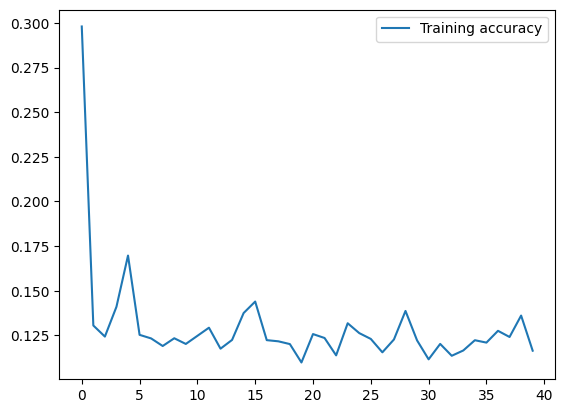

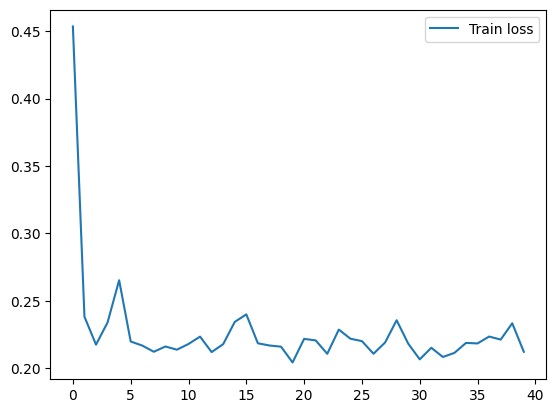

In [44]:
model = grid_search(params, x_train, y_train, hold_out_val)
# model.summary()
# test_model(model, x_test, y_test)

47/47 [==============================] - 0s 1ms/step


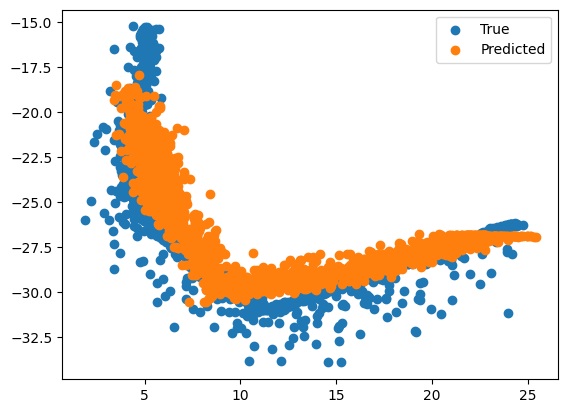

In [39]:
y_train_rescaled = scaler.inverse_transform(y_train)

plt.scatter(y_train_rescaled[:, 0], y_train_rescaled[:, 1], label="True")
pred = model.predict(x_train)
pred = scaler.inverse_transform(pred)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()